<a href="https://colab.research.google.com/github/isaacfinberg/Novozymes-Enzyme-Stability-Prediction/blob/isaac.develop/protbert_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  
!mkdir -p ~/.kaggle                                          
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log 
!cp kaggle.json ~/.kaggle/kaggle.json > log              
!chmod 600 ~/.kaggle/kaggle.json                            
!kaggle config set -n competition -v novozymes-enzyme-stability-prediction   
!kaggle competitions download -c novozymes-enzyme-stability-prediction         
!unzip -o *.zip >> log                           
# !kaggle competitions leaderboard --show                

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: novozymes-enzyme-stability-prediction
novozymes-enzyme-stability-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import pandas as pd
import numpy as np

# df = pd.read_csv('train.csv', low_memory=False); df

In [4]:
# df_test = pd.read_csv('test.csv', low_memory=False)
# df_test.head()

# Read/Format Embeddings

In [5]:
emb_train = pd.read_csv('/content/drive/MyDrive/kaggle_deep_learning/final project/train_embeddings.csv').set_index('seq_id')
emb_test = pd.read_csv('/content/drive/MyDrive/kaggle_deep_learning/final project/test_embeddings.csv', engine='python', error_bad_lines=False).set_index('seq_id')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 26697: unexpected end of data


In [7]:
emb_train['bert_embedding'] = emb_train['bert_embedding'].apply(lambda x: x.strip('][').split(', '))
emb_test['bert_embedding'] = emb_test['bert_embedding'].apply(lambda x: x.strip('][').split(', '))
emb_train = emb_train[['bert_embedding', 'tm']]
emb_test = emb_test[['bert_embedding', 'tm']]

In [34]:
data = []
for i in emb_train.index:
  emb = {j:float(emb_train.loc[i, 'bert_embedding'][j]) for j in range(1024)}
  emb.update({'tm': emb_train.loc[i, 'tm']})
  data.append(emb)

In [35]:
data = pd.DataFrame(data)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,tm
0,-0.256925,0.271155,-0.244614,-0.259322,-0.277600,-0.271604,-0.269424,-0.266613,0.250350,-0.262595,...,-0.254393,0.268699,-0.266278,-0.264293,-0.248284,0.254902,0.258594,0.241834,-0.264002,75.7
1,-0.265456,0.280060,-0.252809,-0.267916,-0.286670,-0.280521,-0.278284,-0.275400,0.258703,-0.271277,...,-0.262856,0.277541,-0.275056,-0.273019,-0.256581,0.263378,0.267170,0.249951,-0.272721,50.5
2,-0.260598,0.274973,-0.248154,-0.263019,-0.281481,-0.275426,-0.273225,-0.270386,0.253953,-0.266327,...,-0.258039,0.272493,-0.270047,-0.268041,-0.251865,0.258553,0.262284,0.245344,-0.267748,40.5
3,-0.244937,0.258626,-0.233111,-0.247241,-0.264832,-0.259059,-0.256959,-0.254255,0.238619,-0.250390,...,-0.242503,0.256261,-0.253933,-0.252023,-0.236635,0.242993,0.246541,0.230441,-0.251743,47.2
4,-0.282981,0.298361,-0.269637,-0.285574,-0.305312,-0.298844,-0.296492,-0.293455,0.275860,-0.289115,...,-0.280240,0.295709,-0.293094,-0.290949,-0.273620,0.280789,0.284788,0.266621,-0.290635,49.5


# Tree based regressor

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_extraction import text
from sklearn.random_projection import GaussianRandomProjection
from scipy import stats
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

SEED = 0

In [38]:
train_X, test_X, train_y, test_y = train_test_split(data.iloc[:, :-1], data['tm'], test_size=1000, random_state=SEED, shuffle=True)

In [39]:
regressor = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', 
                                      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
                                      init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, 
                                      validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
regressor.fit(train_X, train_y)

GradientBoostingRegressor()

In [41]:
regressor2 = XGBRegressor()
regressor2.fit(train_X, train_y)

[00:13:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [42]:
preds = regressor2.predict(test_X)
spearman = stats.spearmanr(test_y, preds)
print(spearman)

SpearmanrResult(correlation=0.05260756335281955, pvalue=0.09637892359018889)


(array([  1.,  29.,  60., 335., 395.,  87.,  49.,  39.,   4.,   1.]),
 array([  0. ,  11.6,  23.2,  34.8,  46.4,  58. ,  69.6,  81.2,  92.8,
        104.4, 116. ]),
 <a list of 10 Patch objects>)

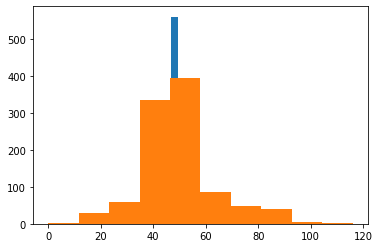

In [48]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.hist(preds)
plt.hist(test_y)

In [ ]:
# test_final = trans_seq.transform(df_test['protein_sequence'])
# test_final = projector.transform(test_final)
# # test_final = scaler.transform(test_final)

In [ ]:
# test_final = trans_seq.transform(df_test['protein_sequence'])
# test_final = projector.transform(test_final)
# test_final = scaler.transform(test_final)
# predictions = model.predict(test_final)

# ToCSV = lambda df_tmp, fname: df_tmp.to_csv(f'{fname}.csv', index_label='seq_id')
# pY = pd.DataFrame(predictions, index=range(31390,len(predictions)+31390), columns=['tm'])
# ToCSV(pY, './MySubmission')

76/76 [==============================] - 0s 2ms/step
